# Looking for the H alpha Raman wings in SMC-N66 (NGC 346)

Start off the same as the other notebooks - import the libraries and load the data

In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Cube
sns.set_context("talk")

In [2]:
datapath = Path("/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/")
fitsfilepath = datapath / "ADP.2017-10-16T11_04_19.247.fits"
cube = Cube(str(fitsfilepath))
hacube = cube.select_lambda(6200.0, 6800.0)
cube_mask_orig = cube.mask.copy()
hacube_mask_orig = hacube.mask.copy()

## Deal with the sky correction

*This is a step that is particular to the NGC 346 dataset, and hopefully will not be necessary for other regions.*

I cannot use the same procedure developed in the `03-00-ha-moment-maps` notebook of subtracting off the spectrum from a region where the sky oversubtraction is most apparent. When I tried it, it just increased the noise too much in the wings.

What I will try instead is to simply mask out regions where the Ha line goes negative. 

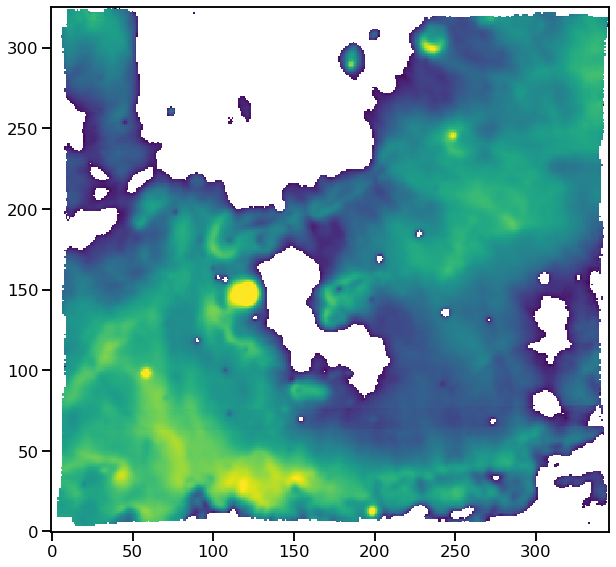

In [3]:
cont6600 = hacube.select_lambda(6600.0, 6620.0).mean(axis=0)
hacore = (hacube.select_lambda(6560.0, 6572.0) - cont6600).sum(axis=0)
fig = plt.figure(figsize=(10, 10))
negmask = (hacore.data < 0.0)
hacore.mask = hacore.mask | negmask
hacore.plot(scale="sqrt", vmax=1e5)

In [4]:
hacube.mask = hacube.mask | negmask[None, :, :]

## Inspect the data cube

The full data cube is in `cube`, while `hacube` is a 600 Å window around Hα.

Looking at the data cube in DS9 I found a region that looks promising fro the Raman wings, so we will look at that first:

[(0.0, 100.0)]

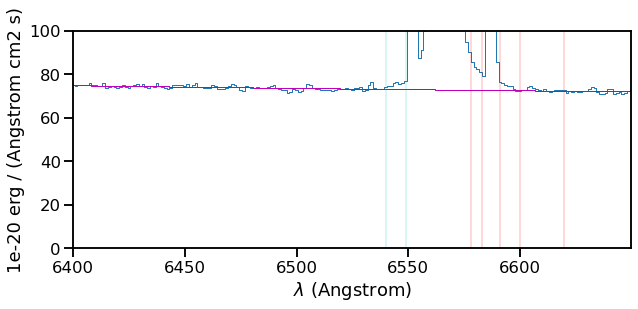

In [5]:
# hacube.mask = (my_mask_3d) | hacube_mask_orig
fig, ax = plt.subplots(figsize=(10, 4))
spec_ha = hacube[:, 240:250, 230:250].mean(axis=(1, 2))
spec2 = spec_ha.copy().subspec(6400, 6650)
spec2.mask_region(6500, 6600)
cont = spec2.poly_spec(2)
spec_ha.plot()
cont.plot(color="m")
ax.axvline(6578, c="r", lw=0.3)
ax.axvline(6583, c="r", lw=0.3)
ax.axvline(6591, c="r", lw=0.3)
ax.axvline(6600, c="r", lw=0.3)
ax.axvline(6620, c="r", lw=0.3)

ax.axvline(6540, c="c", lw=0.3)
ax.axvline(6549, c="c", lw=0.3)



ax.set(ylim=[0, 100])

## Images of different wavelength ranges

So the red wing and blue wing look like they are definitely there. The red wing can be seen on both sides of the [N II] λ6583 line. In Orion, we only see it clearly for $\lambda > 6600$.  Perhaps this is because the C II λ6578 line is weaker in the LMC. 

First, make an image of the outer red wing:

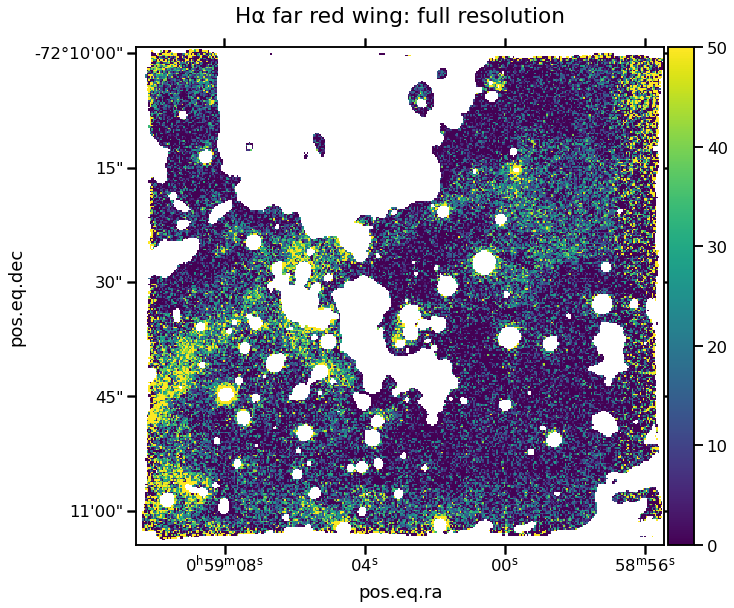

In [6]:
cont6600 = hacube.select_lambda(6600.0, 6620.0).mean(axis=0)
wing = (hacube.select_lambda(6591.0, 6600.0) - cont6600).sum(axis=0)
fig = plt.figure(figsize=(10, 10))
wing.mask = wing.mask | (cont6600.data > 400.0)
wing.plot(
    use_wcs=True,
    vmin=0,
    vmax=50,
    cmap="viridis",
    scale="linear",
    colorbar="v",
)
fig.axes[0].set_title(
    "Hα far red wing: full resolution",
    fontsize="large",
    pad=25,
);

We see filamentary structure that is similar to the other emission lines (see 11-line-profiles notebook).  Note that I am masking out the stars by using a condition on `cont6600`.  It is a delicate balancing act between cutting out the PSF wings of the srars without losing too much of the nebular emission.


The map is very noisy but we can try and improve things by rebinning to 8x8.  I also take the opportunity to trim off a 10-pixel margin all around, since there are some very noisy pixels there.

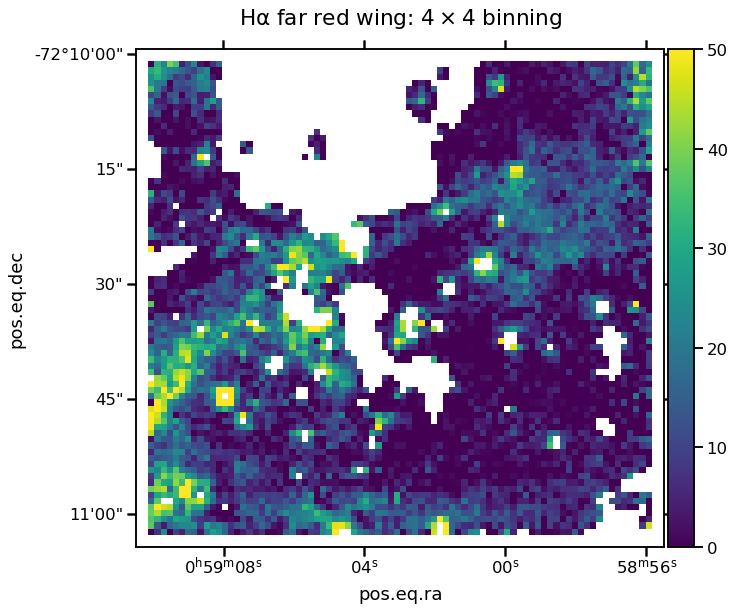

In [7]:
fig = plt.figure(figsize=(10, 10))
margin = 10
wing.mask[:margin, :] = True
wing.mask[-margin:, :] = True
wing.mask[:, :margin] = True
wing.mask[:, -margin:] = True
wing.rebin(4).plot(
    use_wcs=True,
    vmin=0,
    vmax=50,
    cmap="viridis",
    scale="linear",
    colorbar="v",
)
fig.axes[0].set_title(
    r"Hα far red wing: $4\times4$ binning",
    fontsize="large",
    pad=25,
);

This looks a lot better.  We can see the central filament a lot more clearly. 

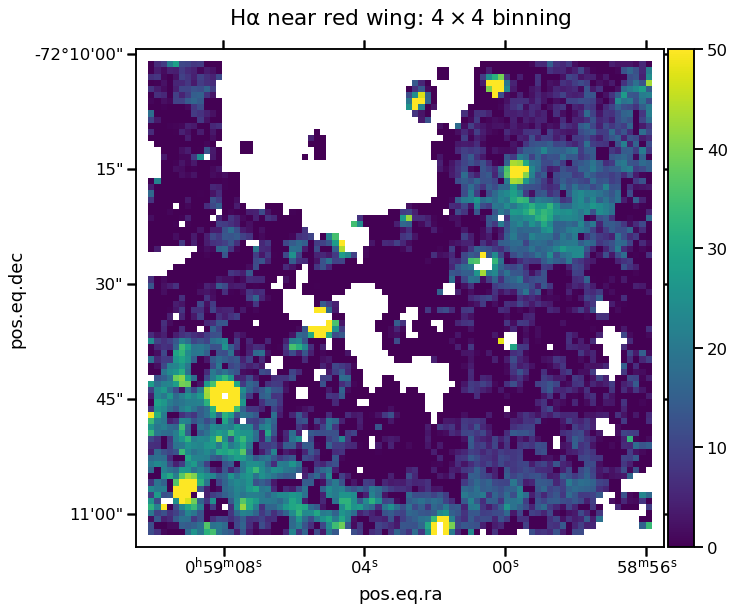

In [8]:
inwing = (hacube.select_lambda(6578.0, 6583.0) - cont6600).sum(axis=0)
fig = plt.figure(figsize=(10, 10))
inwing.mask = inwing.mask | (cont6600.data > 400.0)
margin = 10
inwing.mask[:margin, :] = True
inwing.mask[-margin:, :] = True
inwing.mask[:, :margin] = True
inwing.mask[:, -margin:] = True
inwing.rebin(4).plot(
    use_wcs=True,
    vmin=0,
    vmax=50,
    cmap="viridis",
    scale="linear",
    colorbar="v",
)
fig.axes[0].set_title(
    r"Hα near red wing: $4\times4$ binning",
    fontsize="large",
    pad=25,
);

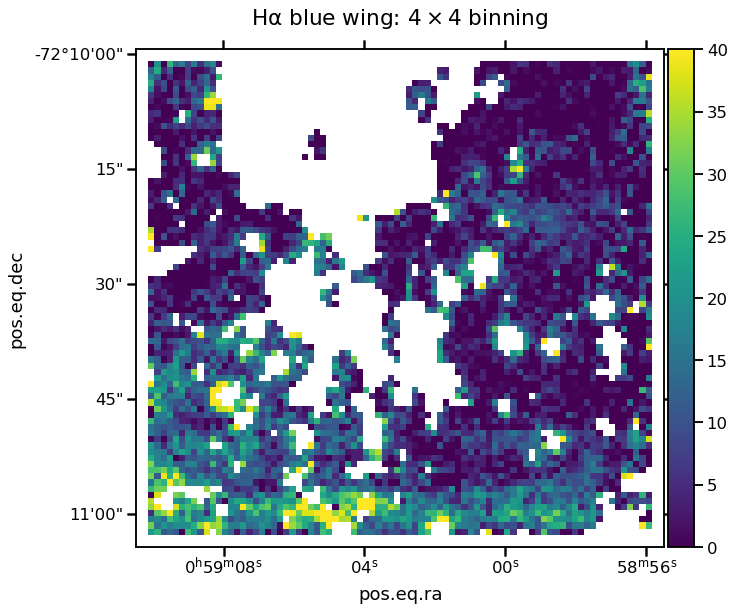

In [9]:
bluewing = (hacube.select_lambda(6540.0, 6549.0) - cont6600).sum(axis=0)
fig = plt.figure(figsize=(10, 10))
bluewing.mask = bluewing.mask | (cont6600.data > 100.0)
bluewing.mask[:margin, :] = True
bluewing.mask[-margin:, :] = True
bluewing.mask[:, :margin] = True
bluewing.mask[:, -margin:] = True
bluewing.rebin(4).plot(
    use_wcs=True,
    vmin=0,
    vmax=40,
    cmap="viridis",
    scale="linear",
    colorbar="v",
)
fig.axes[0].set_title(
    r"Hα blue wing: $4\times4$ binning",
    fontsize="large",
    pad=25,
);

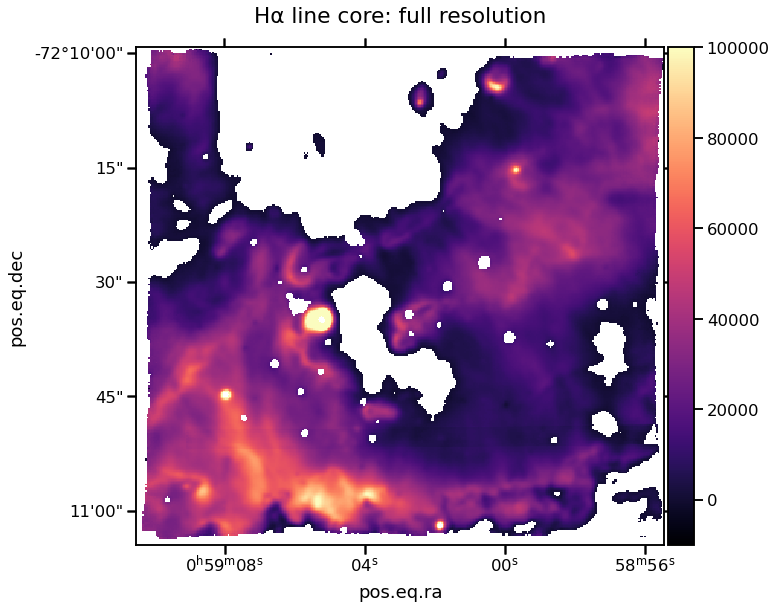

In [10]:
hacore = (hacube.select_lambda(6555.0, 6578.0) - cont6600).sum(axis=0)
fig = plt.figure(figsize=(10, 10))
hacore.mask = hacore.mask | (cont6600.data > 3000.0)
hacore.rebin(1).plot(
    use_wcs=True,
    vmin=-10000,
    vmax=1e5,
    cmap="magma",
    scale="linear",
    colorbar="v",
)
fig.axes[0].set_title(
    "Hα line core: full resolution",
    fontsize="large",
    pad=25,
);

## Extract spectrum for rectangular regions

Make some box regions for extracting the spectra.  I use the astropy affiliated `regions` package (see [docs](https://astropy-regions.readthedocs.io/en/latest/))

In [11]:
import regions

I make four boxes. The first two are in regions where the Raman wing is strong, while the second two are where it is weak. 

In [12]:
boxes = [
    # regions.BoundingBox(iymin=100, iymax=140, ixmin=15, ixmax=40),
    regions.BoundingBox(iymin=75, iymax=140, ixmin=15, ixmax=40),
    # regions.BoundingBox(iymin=180, iymax=240, ixmin=240, ixmax=300),
    regions.BoundingBox(iymin=200, iymax=250, ixmin=210, ixmax=300),
    regions.BoundingBox(iymin=10, iymax=50, ixmin=100, ixmax=150),
    regions.BoundingBox(iymin=10, iymax=100, ixmin=200, ixmax=300),
    regions.BoundingBox(iymin=170, iymax=210, ixmin=90, ixmax=120),
]

Plot an image of the entire bandbass in pixel coordinates and plot the boxes on top of it:

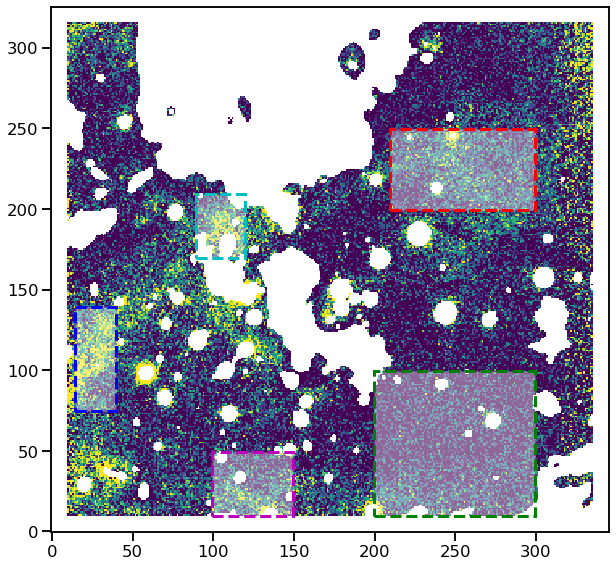

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
wing.rebin(1).plot(
    vmin=0,
    vmax=50,
    scale="linear",
)
for box, c in zip(boxes, "brmgc"):
    box.plot( 
        ax=ax, 
        lw=3, 
        edgecolor=c, 
        linestyle="dashed",
        facecolor=(1.0, 1.0, 1.0, 0.4), 
        fill=True,
    );

We can get the pixel slices from each box like this:

In [14]:
boxes[0].slices

(slice(75, 140, None), slice(15, 40, None))

So we can extract the spectrum for each box.  We apply the `wing` mask that we used above to the cube. (This is a much simpler way of combining a 2D and 3D mask). 

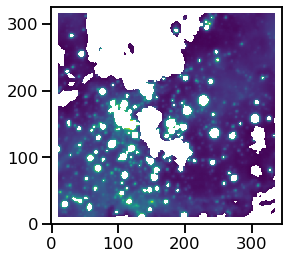

In [15]:
hacube.mask = hacube.mask | wing.mask[None, :, :]
hacube.sum(axis=0).plot()

I plot the spectrum for each box and also fit the continuum, so we can easily see if there are any Raman wings present.

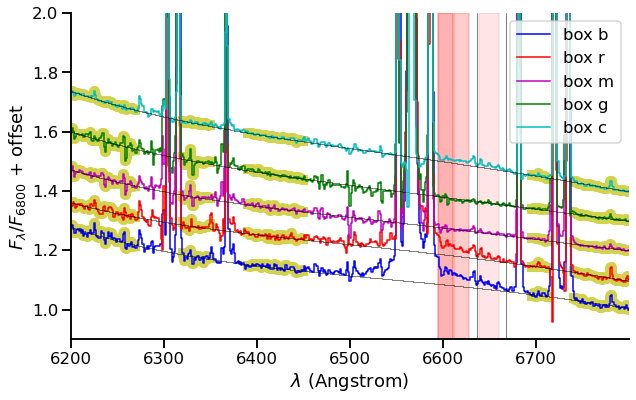

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
offset = 0.0
for box, c in zip(boxes, "brmgc"):
    yslice, xslice = box.slices
    spec = hacube[:, yslice, xslice].mean(axis=(1, 2))
    spec /= spec[-1]
    spec += offset
    spec.plot(c=c, linewidth=1.5, label=f"box {c}")
    spec2 = spec.copy()
    #spec2.mask_region(6200, 6320)
    spec2.mask_region(6270, 6320)
    spec2.mask_region(6350, 6390)
    spec2.mask_region(6450, 6695)
    spec2.mask_region(6712, 6740)
    cont = spec2.poly_spec(4)
    cont.plot(c="k", linewidth=0.5)
    spec2.plot(c="y", linewidth=10, alpha=0.7, zorder=-100)
    offset += 0.1

ax.axvline(6633.0 * (1.0 + 160/3e5), color="k", lw=0.5)
ax.axvline(6664.0 * (1.0 + 160/3e5), color="k", lw=0.5)

ax.axvspan(6594.20, 6611.20, color="r", alpha=0.3, zorder=-100)
ax.axvspan(6612.05, 6628.20, color="r", alpha=0.2, zorder=-100)
ax.axvspan(6638.40, 6660.5, color="r", alpha=0.1, zorder=-100)

ax.legend()
ax.set(ylim=[0.9,2.0], ylabel=r"$F_\lambda / F_{6800}$ + offset")
sns.despine()

The two boxes that were selected to cover the central filament (blue and red) show clear wings.  Better seen on the red side, but also there on the blue.

The other two boxes, which are off the filament (magenta and green) show no Raman wings at all.

The thick yellow lines show the wavelength sections that are used for fitting the continuum (3rd-order polynomial).

I have put vertical lines at the wavelengths of the 6633 and 6664 features, assuming redshift of 160 km/s.  The 6633 feature is in the middle of two emission lines. What are they? **Could be night sky airglow lines**

## Choose suitable bands to measure the Raman wings

In the Orion paper, we have the 3 closest bands in the red wing: R040, R058, R087.  These are marked by pink boxes in the previous figure. 

In order to stand a chance of getting good maps, we need to get a better estimate of the continuum than the cont6600 that we used above, since this includes part of the Raman wing that we want to measure.

On the other hand, fitting a 3rd of 4th order polynomial, like we just did for the rectangular boxes is not practical since the individual pixels are too noisy. 

A compromise would be to fit a linear trend between the continuum around 6400 and the continuum around 6700.   

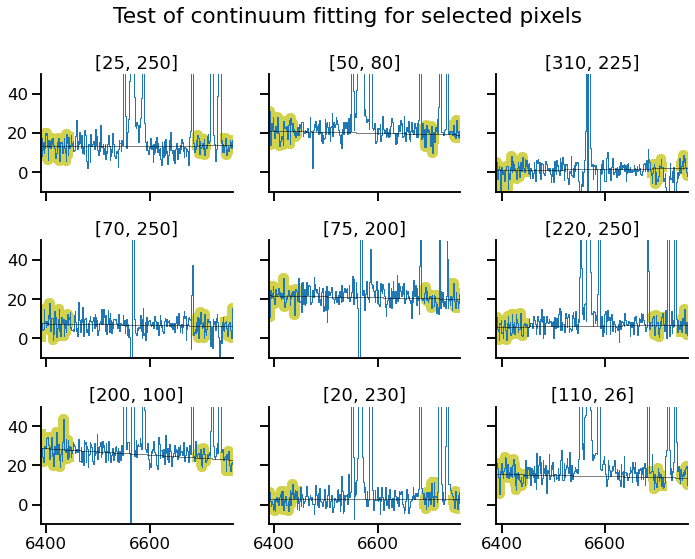

In [17]:
spec4fit = hacube.copy().select_lambda(6390, 6760)

testpixels = [
    [25, 250],
    [50, 80],
    [310, 225],
    [70, 250],
    [75, 200],
    [220, 250],
    [200, 100],
    [20, 230],
    [110, 26],  
]
fig, axes = plt.subplots(
    3,
    3,
    figsize=(10, 8),
    sharex=True,
    sharey="row",
)
for (j, i), ax in zip(testpixels, axes.flat):
    spec1d = spec4fit.copy()[:, j, i]
    spec1d.mask_region(6445, 6690)
    spec1d.mask_region(6710, 6745)
    cont = spec1d.poly_spec(1)
    spec4fit[:, j, i].plot(ax=ax)
    cont.plot(ax=ax, linewidth=0.5, c="k")
    spec1d.plot(ax=ax, c="y", linewidth=10, alpha=0.7, zorder=-100)
    ax.set(xlabel="", ylabel="")
    ax.set_title(f"[{j}, {i}]")
axes[0, 0].set(ylim=[-10, 50])
axes[1, 0].set(ylim=[-10, 50])
axes[2, 0].set(ylim=[-10, 50])
fig.suptitle("Test of continuum fitting for selected pixels")
sns.despine()
fig.tight_layout()

That seems to have worked OK.  Now we need to do this for every pixel. 

## Fit the continuum pixel-by-pixel to the whole cube

In [37]:
from mpdaf.obj import iter_spe

spec4fit = hacube.copy().select_lambda(6390, 6760)
spec4fit.mask = spec4fit.mask | spec1d.mask[:, None, None]
cont_cube = spec4fit.clone(data_init=np.empty, var_init=np.zeros)

In [ ]:
# TOO SLOW - DO NOT RUN!
#
#for sp, co in zip(iter_spe(spec4fit), iter_spe(cont_cube)):
#    if not np.alltrue(sp.mask):
#        co[:] = sp.poly_spec(1)

This is ridiculously slow.  I need to rewrite it to do my own continuum fitting.  It turns out that the problem is that iterating over the individual `Spectrum` objects in a `Cube` is very inefficient.  So I have to make sure to iterate over just the `.data` components, which are numpy arrays. 

In [55]:
from numpy.polynomial import Chebyshev as T
import itertools

In [75]:
nv, ny, nx = spec4fit.shape
wavs = spec4fit.wave.coord()

In [76]:
spec1d = spec4fit.mean(axis=(1, 2))
spec1d.mask_region(6445, 6690)
spec1d.mask_region(6710, 6745)

m = ~spec1d.mask
m.sum(), m.shape

(71, (297,))

In [77]:
for j, i in itertools.product(range(ny), range(nx)):
    spec1d = spec4fit.data[:, j, i]
    if i == 100 and j % 10 == 0:
        print(j, m.sum())
    try:
        p = T.fit(wavs[m], spec1d[m], deg=1)
        cont_cube.data[:, j, i] = p(wavs)
    except:
        pass

0 71
10 71
20 71
30 71
40 71
50 71
60 71
70 71
80 71
90 71
100 71
110 71
120 71
130 71
140 71
150 71
160 71
170 71
180 71
190 71
200 71
210 71
220 71
230 71
240 71
250 71
260 71
270 71
280 71
290 71
300 71
310 71
320 71


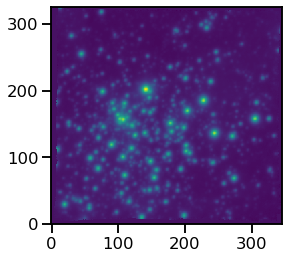

In [80]:
cont_cube.sum(axis=0).plot(scale="log")

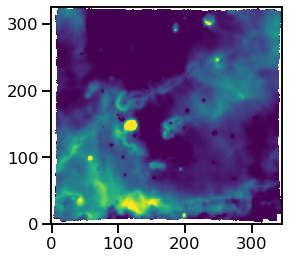

In [84]:
(spec4fit - cont_cube).sum(axis=0).plot(vmin=0, vmax=1e5)

In [86]:
spec4fit.mask = spec4fit.mask | negmask[None, :, :]
cont_cube.mask = cont_cube.mask | negmask[None, :, :]

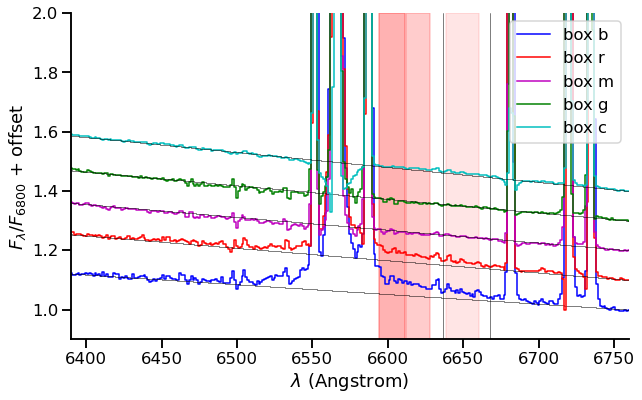

In [88]:
fig, ax = plt.subplots(figsize=(10, 6))
offset = 0.0
for box, c in zip(boxes, "brmgc"):
    yslice, xslice = box.slices
    spec = spec4fit[:, yslice, xslice].mean(axis=(1, 2))
    spec /= spec[-1]
    spec += offset
    cont = cont_cube[:, yslice, xslice].mean(axis=(1, 2))
    cont /= cont[-1]
    cont += offset
    spec.plot(c=c, linewidth=1.5, label=f"box {c}")
    cont.plot(c="k", linewidth=0.5)
    offset += 0.1

ax.axvline(6633.0 * (1.0 + 160/3e5), color="k", lw=0.5)
ax.axvline(6664.0 * (1.0 + 160/3e5), color="k", lw=0.5)

ax.axvspan(6594.20, 6611.20, color="r", alpha=0.3, zorder=-100)
ax.axvspan(6612.05, 6628.20, color="r", alpha=0.2, zorder=-100)
ax.axvspan(6638.40, 6660.5, color="r", alpha=0.1, zorder=-100)

ax.legend()
ax.set(ylim=[0.9,2.0], ylabel=r"$F_\lambda / F_{6800}$ + offset")
sns.despine()

Copy the limits of the Raman bands from the Orion project:

In [89]:
bands = {
    "B133": [6414.85, 6445.45],
    "B080": [6469.25, 6496.45],
    "B054": [6499.85, 6517.7],
    "B033": [6518.55, 6540.65],
    "R040": [6594.2, 6611.2],
    "R058": [6612.05, 6628.2],
    "R087": [6638.4, 6660.5],
    "R136": [6688.55, 6708.95],
}


In [93]:
bandcubes = {}
for band in bands:
    lam1, lam2 = bands[band]
    bandcubes[band] = (spec4fit - cont_cube).select_lambda(lam1, lam2)

## Continuum-subtracted images of the red bands

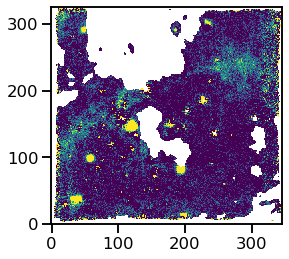

In [96]:
bandcubes["R040"].sum(axis=0).plot(vmin=0, vmax=100)

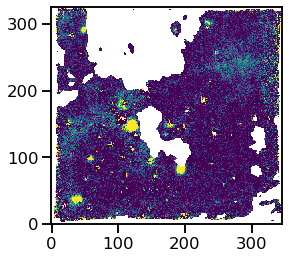

In [97]:
bandcubes["R058"].sum(axis=0).plot(vmin=0, vmax=100)

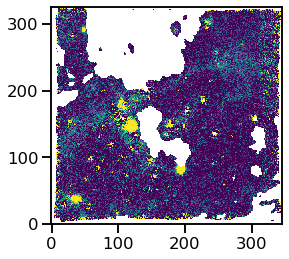

In [98]:
bandcubes["R087"].sum(axis=0).plot(vmin=0, vmax=100)

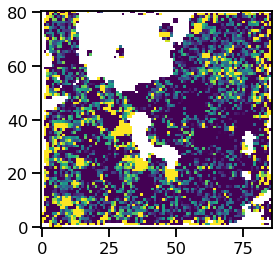

In [128]:
bandcubes["R136"].sum(axis=0).rebin(4).plot(vmin=0, vmax=10)

So, we can se *something* in all the bands, but the first two are best.

## Continuum-subtracted images of the blue bands

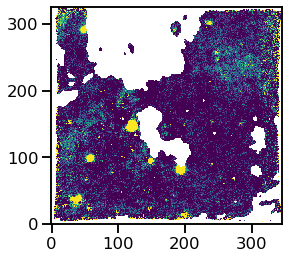

In [100]:
bandcubes["B033"].sum(axis=0).plot(vmin=0, vmax=100)

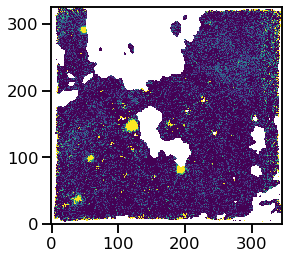

In [101]:
bandcubes["B054"].sum(axis=0).plot(vmin=0, vmax=100)

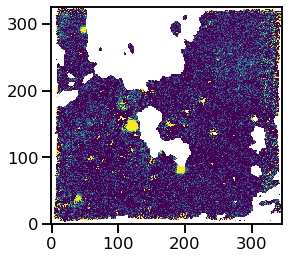

In [102]:
bandcubes["B080"].sum(axis=0).plot(vmin=0, vmax=100)

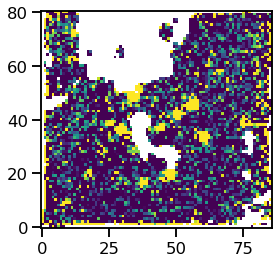

In [131]:
bandcubes["B133"].sum(axis=0).rebin(4).plot(vmin=0, vmax=10)

The last band does not show anything, but the other three do.

## Ratio of wing to core

In [104]:
hacore = (spec4fit - cont_cube).select_lambda(6560.0, 6572.0)

In [109]:
r = ((bandcubes["R040"].sum(axis=0) +  bandcubes["R058"].sum(axis=0)) / hacore.sum(axis=0))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


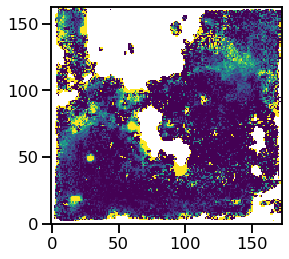

In [124]:
r.rebin(2).plot(vmin=0, vmax=0.005)

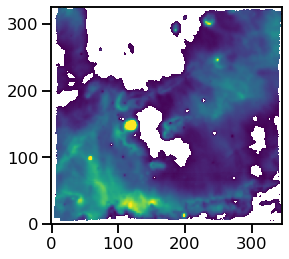

In [120]:
hacore.sum(axis=0).plot(vmin=0, vmax=1e5)

This shows a clear difference in distribution between the wings and the core.